In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import cvxpy as cp
from fancyimpute import MatrixFactorization
from fancyimpute import SoftImpute
import pandas as pd
from numpy.linalg import svd

In [2]:
def generate_low_rank_matrix(m, n, r, loc,sigma, seed=None):   

    assert r <= min(m, n)
    if seed is not None:
        np.random.seed(seed)

    A = np.random.normal(loc=loc, scale=sigma, size=(m,r)) 
    B = np.random.normal(loc=loc, scale=sigma, size=(r,n))
    M = A @ B  

    return M



def mask_matrix_with_noise(A, keep_ratio=0.2, sigma=0.1, seed=None):   #掩码＋噪音函数
  
    assert 0 < keep_ratio <= 1, "keep_ratio 必须在 (0, 1] 之间"
    if seed is not None:
        np.random.seed(seed)

    m, n = A.shape
    total = m * n
    num_keep = int(keep_ratio * total)


    indices = np.random.permutation(total)
    keep_indices = indices[:num_keep]

    
    mask = np.zeros(total, dtype=bool)
    mask[keep_indices] = True
    mask = mask.reshape(m, n)

    
    A_masked = A.copy()
    noise = np.random.normal(loc=0.0, scale=sigma, size=A.shape)
    A_masked[mask] += noise[mask]      
    A_masked[~mask] = np.nan          

    return A_masked, mask.astype(int)



def split_matrix_exactly(A, k):

    m, n = A.shape

   
    if not isinstance(k, int) or k <= 0:
        raise ValueError("k (子矩阵数量) 必须是一个正整数。")
    rows_per_block = m // k 
    indices = np.arange(k + 1) * rows_per_block
    blocks = [A[indices[i]:indices[i+1], :] for i in range(k)]

    return blocks

def compute_error(M_true, X_recovered, eps=1e-8, mode="Fro"):
    if mode=="Fro":
       return np.linalg.norm(X_recovered - M_true, 'fro')
    if mode=="rel":
       return np.linalg.norm(X_recovered - M_true, 'fro')/(np.linalg.norm(M_true, 'fro') + eps)
    if mode=="inf":
       return np.max(np.abs(X_recovered - M_true))


def truncated_svd(M, r=None, tol=1e-10):
    U, S, Vt = np.linalg.svd(M, full_matrices=False)

    if r is None:
        r = np.sum(S > tol)  
    
    U_r = U[:, :r]
    S_r = S[:r]
    Vt_r = Vt[:r, :]
    return U_r, S_r, Vt_r    

def distributed_eigenspace_estimation(V_list, V_ref=None):
    
    shapes = [V.shape for V in V_list]
    if len(set(shapes)) != 1:
        print("输入矩阵形状不同")
        return None

    m = len(V_list)
    n, r = shapes[0]

    # 设定参考解   这里好像也可以用ensemble的方法
    if V_ref is None:
        V_ref = V_list[0]
    else:
        if V_ref.shape != (n, r):
            print("参考矩阵形状与输入矩阵不一致")
            return None

    
    V_aligned_list = []
    for V_local in V_list:
        M = V_local.T @ V_ref
        U, _, Vt = np.linalg.svd(M,full_matrices=False)
        Z = U @ Vt
        V_aligned = V_local @ Z
        V_aligned_list.append(V_aligned)

    
    V_bar = sum(V_aligned_list) / m

    V_left, R_right = np.linalg.qr(V_bar,'reduced')

    return V_left

def solve_L_with_missing(Y, Vt, lambda_reg=1e-4):
    m, n = Y.shape
    r, n_check = Vt.shape
    assert n == n_check

    L = np.zeros((m, r))
    for i in range(m):
        row = Y[i, :]
        mask = ~np.isnan(row)
        if not np.any(mask):
            continue

        y_obs = row[mask]
        Vt_obs = Vt[:, mask].T

        # Ridge-like regularization
        A = Vt_obs.T @ Vt_obs + lambda_reg * np.eye(r)
        b = Vt_obs.T @ y_obs
        L[i, :] = np.linalg.solve(A, b)

    return L

def debiased_MC(M, p, model="softimpute", rank=None):
    if model == "softimpute":
        Z=SoftImpute(shrinkage_value=0.1, max_iters=100, max_rank=rank, verbose=False).fit_transform(M)
        mask = ~np.isnan(M)
        Z_minus_M = np.zeros_like(Z)
        Z_minus_M[mask] = Z[mask] - M[mask]

        
        Z0 = Z - (1 / p) * Z_minus_M 
        U, S, Vt = svd(Z0, full_matrices=False)
        U_r = U[:, :rank]
        S_r = S[:rank]
        Vt_r = Vt[:rank, :]
        Md = U_r @ np.diag(S_r) @ Vt_r
        return Md


    if model == "sdp":
        m, n = M.shape
        Omega = ~np.isnan(M)
        observed = np.nan_to_num(M, nan=0.0)
        X = cp.Variable((m, n), name="X_completed")
        frobenius_loss = cp.sum_squares(cp.multiply(Omega, X - observed))
        lambda_reg = 1.0
        objective = cp.Minimize(0.5 * frobenius_loss + lambda_reg * cp.norm(X, "nuc"))
        problem = cp.Problem(objective)
        problem.solve(solver=cp.SCS, verbose=False)
        if problem.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
             Z = X.value

        mask = ~np.isnan(M)
        Z_minus_M = np.zeros_like(Z)
        Z_minus_M[mask] = Z[mask] - M[mask]

        
        Z0 = Z - (1 / p) * Z_minus_M 
        U, S, Vt = svd(Z0, full_matrices=False)
        U_r = U[:, :rank]
        S_r = S[:rank]
        Vt_r = Vt[:rank, :]
        Md = U_r @ np.diag(S_r) @ Vt_r
        return Md

**fix p=0.2, rank=2 U(5n,2) and V(100,2), $M=UV^t$  and $U_{ij} \sim N (0,1)$ ,$V_{ij} \sim N (0,1)$,$E_{ij} \sim N (0,0.1) (soft impute)$**

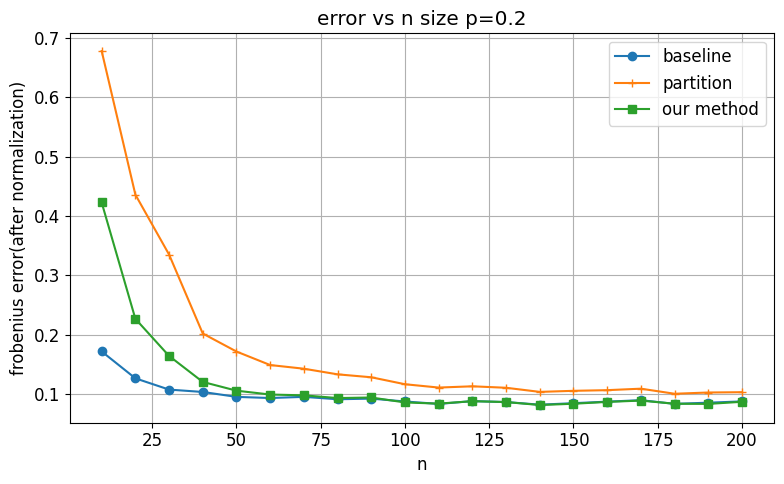

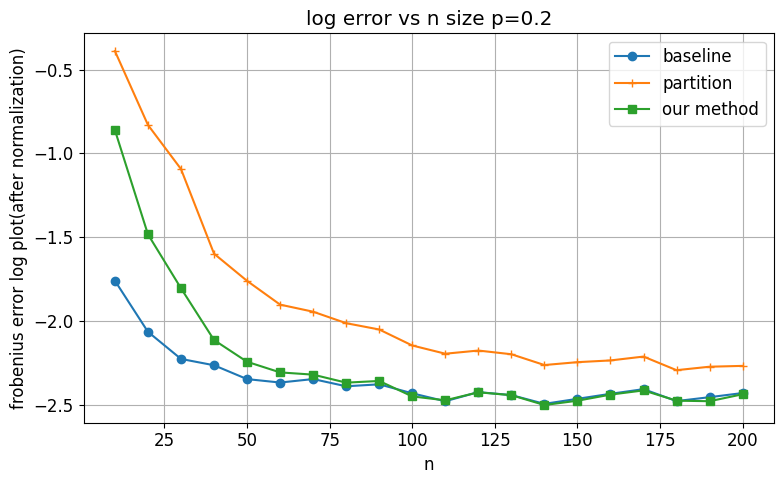

In [10]:
n_size=[10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
baseline=[]
our_method=[]
partition=[]
for n in n_size:
    baseline_list=[]
    our_method_list=[]
    partition_list=[]

    
    M_true=generate_low_rank_matrix(5*n,100,2,0,1,seed=42)
    noise = np.random.normal(loc=0.0, scale=np.sqrt(0.1), size=M_true.shape)
    M = M_true + noise
    blocks_true=split_matrix_exactly(M_true,5)
    blocks = split_matrix_exactly(M,5)

    for trial in range(5):
            ratio=0.2     ##here we can change hyperparameter observed entires percentage
            M_masked = mask_matrix_with_noise(M, keep_ratio=ratio, sigma=0, seed=None)[0]     
            block_masked=split_matrix_exactly(M_masked,5)

            #baseline
            recovery_baseline = debiased_MC(M_masked, p=ratio, model="softimpute", rank=2)
            baseline_list.append(compute_error(M_true, recovery_baseline,mode="rel"))    #here we normalize the error

            #partition
            recovered_blocks = [debiased_MC(blk, p=ratio, model="softimpute", rank=2) for blk in block_masked]
            recovery_partition = np.vstack(recovered_blocks)
            partition_list.append(compute_error(M_true, recovery_partition,mode="rel"))


            #our method
            V_list=[truncated_svd(blk_completed, r=2, tol=1e-10)[2].T for blk_completed in recovered_blocks]
            V_align=distributed_eigenspace_estimation(V_list, V_ref=None)
            recovery_blocks_our_method=[solve_L_with_missing(m, V_align.T)@ V_align.T for m in block_masked]
            recovery_our_method=np.vstack(recovery_blocks_our_method)
            our_method_list.append(compute_error(M_true, recovery_our_method,mode="rel"))
            
            
        
            



    baseline.append(np.mean(baseline_list))
    partition.append(np.mean(partition_list))
    our_method.append(np.mean(our_method_list))


#plotting
plt.rcParams.update({'font.size': 12})



plt.figure(figsize=(8, 5))
plt.plot(n_size, baseline, marker='o', label='baseline')
plt.plot(n_size, partition, marker='+', label='partition')
plt.plot(n_size, our_method, marker='s', label='our method')

plt.xlabel('n')
plt.ylabel('frobenius error(after normalization)')
plt.title('error vs n size p=0.2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()        

plt.rcParams.update({'font.size': 12})



plt.figure(figsize=(8, 5))
plt.plot(n_size, np.log(baseline), marker='o', label='baseline')
plt.plot(n_size, np.log(partition), marker='+', label='partition')
plt.plot(n_size, np.log(our_method), marker='s', label='our method')

plt.xlabel('n')
plt.ylabel('frobenius error log plot(after normalization)')
plt.title('log error vs n size p=0.2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()        

**fix p=0.1, rank=2 U(5n,2) and V(100,2), $M=UV^t$  and $U_{ij} \sim N (0,1)$ ,$V_{ij} \sim N (0,1)$,$E_{ij} \sim N (0,0.1) (soft impute)$**

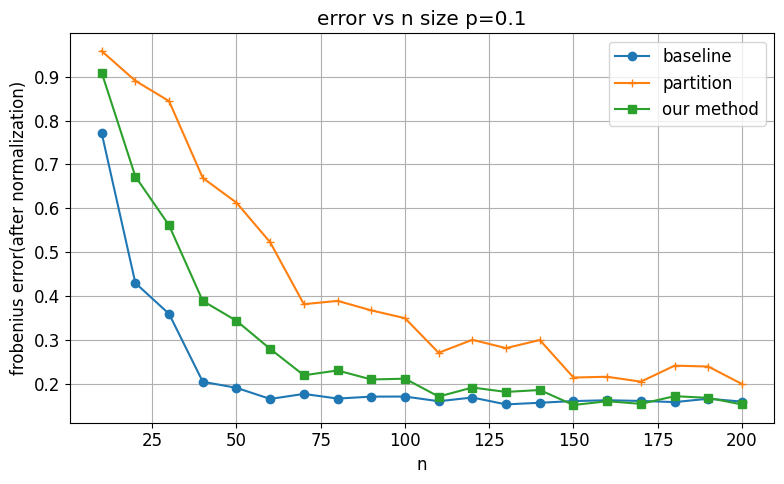

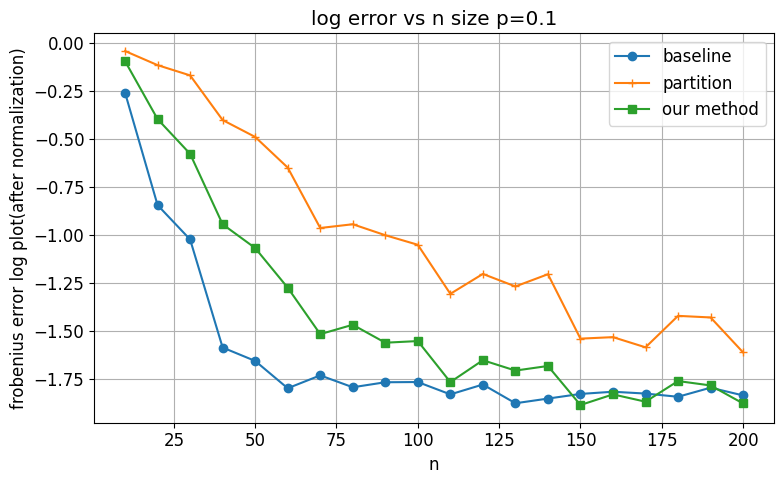

In [11]:
n_size=[10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
baseline=[]
our_method=[]
partition=[]
for n in n_size:
    baseline_list=[]
    our_method_list=[]
    partition_list=[]

    
    M_true=generate_low_rank_matrix(5*n,100,2,0,1,seed=42)
    noise = np.random.normal(loc=0.0, scale=np.sqrt(0.1), size=M_true.shape)
    M = M_true + noise
    blocks_true=split_matrix_exactly(M_true,5)
    blocks = split_matrix_exactly(M,5)

    for trial in range(5):
            ratio=0.1     ##here we can change hyperparameter observed entires percentage
            M_masked = mask_matrix_with_noise(M, keep_ratio=ratio, sigma=0, seed=None)[0]     
            block_masked=split_matrix_exactly(M_masked,5)

            #baseline
            recovery_baseline = debiased_MC(M_masked, p=ratio, model="softimpute", rank=2)
            baseline_list.append(compute_error(M_true, recovery_baseline,mode="rel"))    #here we normalize the error

            #partition
            recovered_blocks = [debiased_MC(blk, p=ratio, model="softimpute", rank=2) for blk in block_masked]
            recovery_partition = np.vstack(recovered_blocks)
            partition_list.append(compute_error(M_true, recovery_partition,mode="rel"))


            #our method
            V_list=[truncated_svd(blk_completed, r=2, tol=1e-10)[2].T for blk_completed in recovered_blocks]
            V_align=distributed_eigenspace_estimation(V_list, V_ref=None)
            recovery_blocks_our_method=[solve_L_with_missing(m, V_align.T)@ V_align.T for m in block_masked]
            recovery_our_method=np.vstack(recovery_blocks_our_method)
            our_method_list.append(compute_error(M_true, recovery_our_method,mode="rel"))
            
            
        
            



    baseline.append(np.mean(baseline_list))
    partition.append(np.mean(partition_list))
    our_method.append(np.mean(our_method_list))


#plotting
plt.rcParams.update({'font.size': 12})



plt.figure(figsize=(8, 5))
plt.plot(n_size, baseline, marker='o', label='baseline')
plt.plot(n_size, partition, marker='+', label='partition')
plt.plot(n_size, our_method, marker='s', label='our method')

plt.xlabel('n')
plt.ylabel('frobenius error(after normalization)')
plt.title('error vs n size p=0.1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()        

plt.rcParams.update({'font.size': 12})



plt.figure(figsize=(8, 5))
plt.plot(n_size, np.log(baseline), marker='o', label='baseline')
plt.plot(n_size, np.log(partition), marker='+', label='partition')
plt.plot(n_size, np.log(our_method), marker='s', label='our method')

plt.xlabel('n')
plt.ylabel('frobenius error log plot(after normalization)')
plt.title('log error vs n size p=0.1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()        

**fix p=0.15, rank=2 U(5n,2) and V(100,2), $M=UV^t$  and $U_{ij} \sim N (0,1)$ ,$V_{ij} \sim N (0,1)$,$E_{ij} \sim N (0,0.1) (soft impute)$**

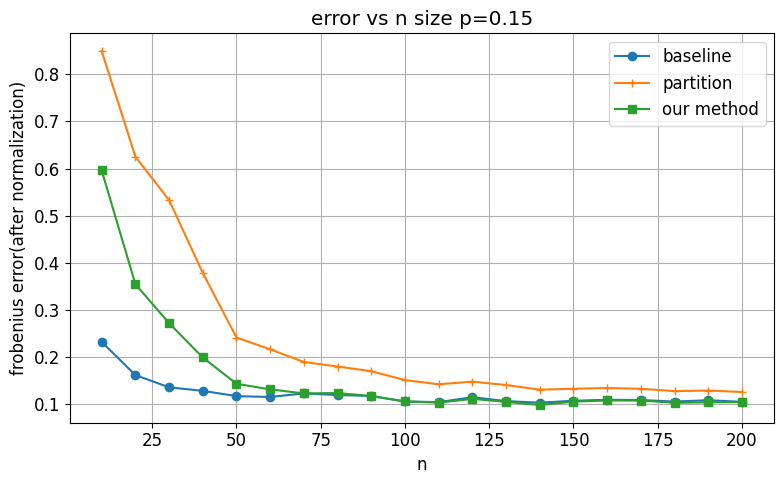

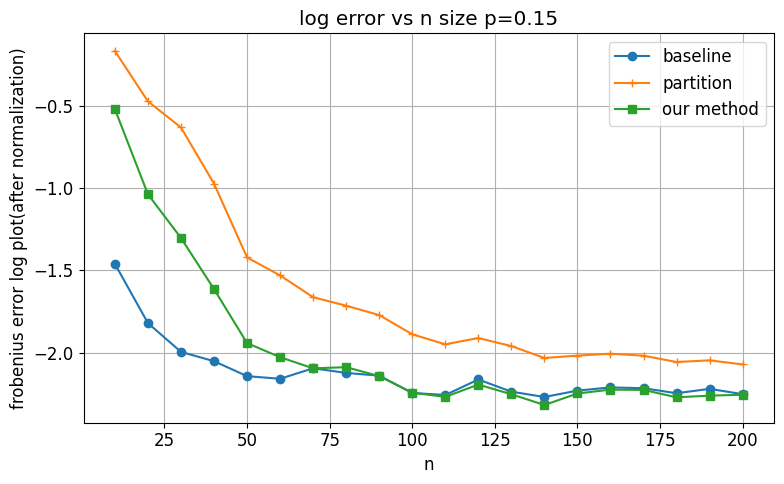

In [12]:
n_size=[10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
baseline=[]
our_method=[]
partition=[]
for n in n_size:
    baseline_list=[]
    our_method_list=[]
    partition_list=[]

    
    M_true=generate_low_rank_matrix(5*n,100,2,0,1,seed=42)
    noise = np.random.normal(loc=0.0, scale=np.sqrt(0.1), size=M_true.shape)
    M = M_true + noise
    blocks_true=split_matrix_exactly(M_true,5)
    blocks = split_matrix_exactly(M,5)

    for trial in range(5):
            ratio=0.15     ##here we can change hyperparameter observed entires percentage
            M_masked = mask_matrix_with_noise(M, keep_ratio=ratio, sigma=0, seed=None)[0]     
            block_masked=split_matrix_exactly(M_masked,5)

            #baseline
            recovery_baseline = debiased_MC(M_masked, p=ratio, model="softimpute", rank=2)
            baseline_list.append(compute_error(M_true, recovery_baseline,mode="rel"))    #here we normalize the error

            #partition
            recovered_blocks = [debiased_MC(blk, p=ratio, model="softimpute", rank=2) for blk in block_masked]
            recovery_partition = np.vstack(recovered_blocks)
            partition_list.append(compute_error(M_true, recovery_partition,mode="rel"))


            #our method
            V_list=[truncated_svd(blk_completed, r=2, tol=1e-10)[2].T for blk_completed in recovered_blocks]
            V_align=distributed_eigenspace_estimation(V_list, V_ref=None)
            recovery_blocks_our_method=[solve_L_with_missing(m, V_align.T)@ V_align.T for m in block_masked]
            recovery_our_method=np.vstack(recovery_blocks_our_method)
            our_method_list.append(compute_error(M_true, recovery_our_method,mode="rel"))
            
            
        
            



    baseline.append(np.mean(baseline_list))
    partition.append(np.mean(partition_list))
    our_method.append(np.mean(our_method_list))


#plotting
plt.rcParams.update({'font.size': 12})



plt.figure(figsize=(8, 5))
plt.plot(n_size, baseline, marker='o', label='baseline')
plt.plot(n_size, partition, marker='+', label='partition')
plt.plot(n_size, our_method, marker='s', label='our method')

plt.xlabel('n')
plt.ylabel('frobenius error(after normalization)')
plt.title('error vs n size p=0.15')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()        

plt.rcParams.update({'font.size': 12})



plt.figure(figsize=(8, 5))
plt.plot(n_size, np.log(baseline), marker='o', label='baseline')
plt.plot(n_size, np.log(partition), marker='+', label='partition')
plt.plot(n_size, np.log(our_method), marker='s', label='our method')

plt.xlabel('n')
plt.ylabel('frobenius error log plot(after normalization)')
plt.title('log error vs n size p=0.15')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()        

**fix p=0.05, rank=2 U(5n,2) and V(100,2), $M=UV^t$  and $U_{ij} \sim N (0,1)$ ,$V_{ij} \sim N (0,1)$,$E_{ij} \sim N (0,0.1) (soft impute)$**

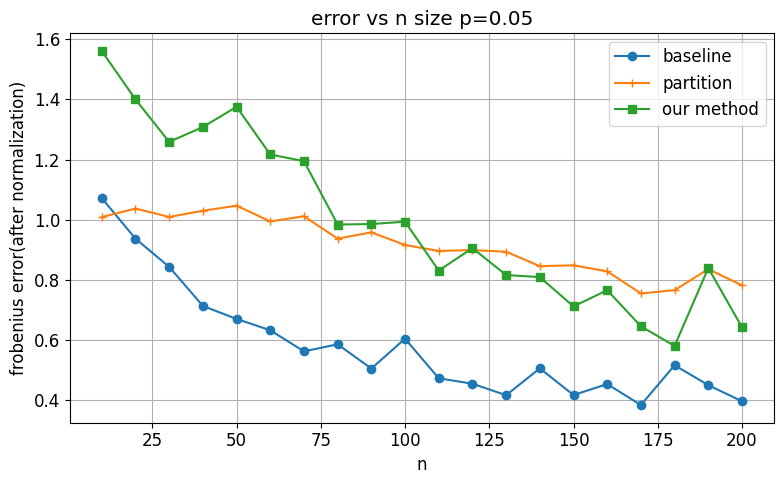

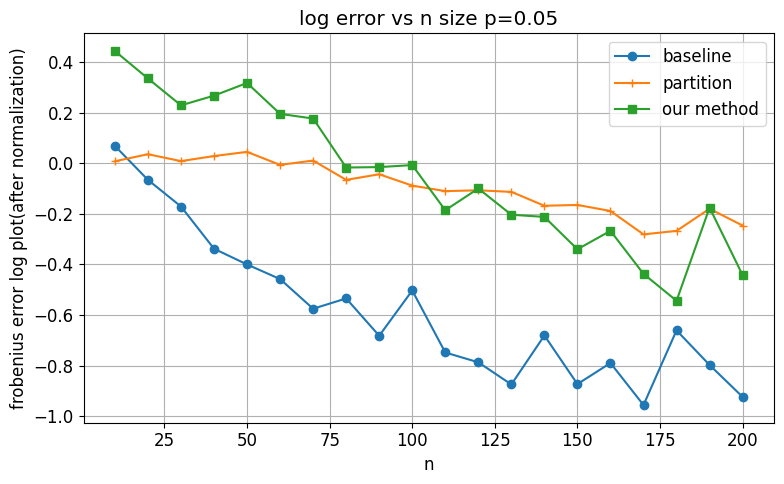

In [13]:
n_size=[10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
baseline=[]
our_method=[]
partition=[]
for n in n_size:
    baseline_list=[]
    our_method_list=[]
    partition_list=[]

    
    M_true=generate_low_rank_matrix(5*n,100,2,0,1,seed=42)
    noise = np.random.normal(loc=0.0, scale=np.sqrt(0.1), size=M_true.shape)
    M = M_true + noise
    blocks_true=split_matrix_exactly(M_true,5)
    blocks = split_matrix_exactly(M,5)

    for trial in range(5):
            ratio=0.05     ##here we can change hyperparameter observed entires percentage
            M_masked = mask_matrix_with_noise(M, keep_ratio=ratio, sigma=0, seed=None)[0]     
            block_masked=split_matrix_exactly(M_masked,5)

            #baseline
            recovery_baseline = debiased_MC(M_masked, p=ratio, model="softimpute", rank=2)
            baseline_list.append(compute_error(M_true, recovery_baseline,mode="rel"))    #here we normalize the error

            #partition
            recovered_blocks = [debiased_MC(blk, p=ratio, model="softimpute", rank=2) for blk in block_masked]
            recovery_partition = np.vstack(recovered_blocks)
            partition_list.append(compute_error(M_true, recovery_partition,mode="rel"))


            #our method
            V_list=[truncated_svd(blk_completed, r=2, tol=1e-10)[2].T for blk_completed in recovered_blocks]
            V_align=distributed_eigenspace_estimation(V_list, V_ref=None)
            recovery_blocks_our_method=[solve_L_with_missing(m, V_align.T)@ V_align.T for m in block_masked]
            recovery_our_method=np.vstack(recovery_blocks_our_method)
            our_method_list.append(compute_error(M_true, recovery_our_method,mode="rel"))
            
            
        
            



    baseline.append(np.mean(baseline_list))
    partition.append(np.mean(partition_list))
    our_method.append(np.mean(our_method_list))


#plotting
plt.rcParams.update({'font.size': 12})



plt.figure(figsize=(8, 5))
plt.plot(n_size, baseline, marker='o', label='baseline')
plt.plot(n_size, partition, marker='+', label='partition')
plt.plot(n_size, our_method, marker='s', label='our method')

plt.xlabel('n')
plt.ylabel('frobenius error(after normalization)')
plt.title('error vs n size p=0.05')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()        

plt.rcParams.update({'font.size': 12})



plt.figure(figsize=(8, 5))
plt.plot(n_size, np.log(baseline), marker='o', label='baseline')
plt.plot(n_size, np.log(partition), marker='+', label='partition')
plt.plot(n_size, np.log(our_method), marker='s', label='our method')

plt.xlabel('n')
plt.ylabel('frobenius error log plot(after normalization)')
plt.title('log error vs n size p=0.05')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()        

**fix p=0.25, rank=2 U(5n,2) and V(100,2), $M=UV^t$  and $U_{ij} \sim N (0,1)$ ,$V_{ij} \sim N (0,1)$,$E_{ij} \sim N (0,0.1) (soft impute)$**

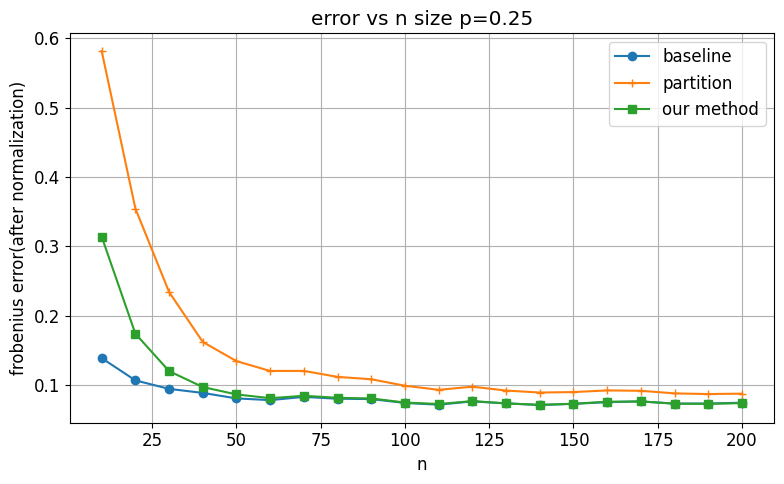

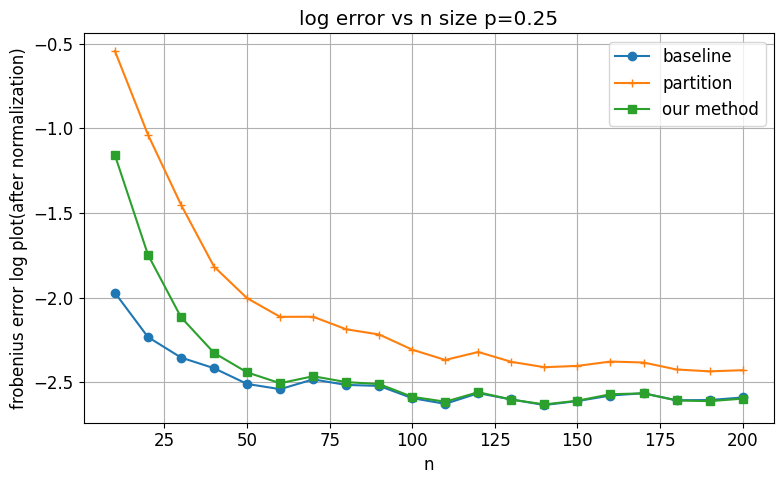

In [14]:
n_size=[10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
baseline=[]
our_method=[]
partition=[]
for n in n_size:
    baseline_list=[]
    our_method_list=[]
    partition_list=[]

    
    M_true=generate_low_rank_matrix(5*n,100,2,0,1,seed=42)
    noise = np.random.normal(loc=0.0, scale=np.sqrt(0.1), size=M_true.shape)
    M = M_true + noise
    blocks_true=split_matrix_exactly(M_true,5)
    blocks = split_matrix_exactly(M,5)

    for trial in range(5):
            ratio=0.25     ##here we can change hyperparameter observed entires percentage
            M_masked = mask_matrix_with_noise(M, keep_ratio=ratio, sigma=0, seed=None)[0]     
            block_masked=split_matrix_exactly(M_masked,5)

            #baseline
            recovery_baseline = debiased_MC(M_masked, p=ratio, model="softimpute", rank=2)
            baseline_list.append(compute_error(M_true, recovery_baseline,mode="rel"))    #here we normalize the error

            #partition
            recovered_blocks = [debiased_MC(blk, p=ratio, model="softimpute", rank=2) for blk in block_masked]
            recovery_partition = np.vstack(recovered_blocks)
            partition_list.append(compute_error(M_true, recovery_partition,mode="rel"))


            #our method
            V_list=[truncated_svd(blk_completed, r=2, tol=1e-10)[2].T for blk_completed in recovered_blocks]
            V_align=distributed_eigenspace_estimation(V_list, V_ref=None)
            recovery_blocks_our_method=[solve_L_with_missing(m, V_align.T)@ V_align.T for m in block_masked]
            recovery_our_method=np.vstack(recovery_blocks_our_method)
            our_method_list.append(compute_error(M_true, recovery_our_method,mode="rel"))
            
            
        
            



    baseline.append(np.mean(baseline_list))
    partition.append(np.mean(partition_list))
    our_method.append(np.mean(our_method_list))


#plotting
plt.rcParams.update({'font.size': 12})



plt.figure(figsize=(8, 5))
plt.plot(n_size, baseline, marker='o', label='baseline')
plt.plot(n_size, partition, marker='+', label='partition')
plt.plot(n_size, our_method, marker='s', label='our method')

plt.xlabel('n')
plt.ylabel('frobenius error(after normalization)')
plt.title('error vs n size p=0.25')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()        

plt.rcParams.update({'font.size': 12})



plt.figure(figsize=(8, 5))
plt.plot(n_size, np.log(baseline), marker='o', label='baseline')
plt.plot(n_size, np.log(partition), marker='+', label='partition')
plt.plot(n_size, np.log(our_method), marker='s', label='our method')

plt.xlabel('n')
plt.ylabel('frobenius error log plot(after normalization)')
plt.title('log error vs n size p=0.25')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()        